In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")
from glob import glob
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
SU2CLC2             SU2CLC2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
MGH                     MGH\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
SU2CLC1            SU2CLC1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [3]:
# cohorts = pd.Series(cohorts).map(size).to_list()
factor = '01_leave-one-target-out'
cohort_order = ['PDL1', 'PD1', 'CTLA4', 'PD1+CTLA4']

save_dir = os.path.join(factor, 'results')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## loading bechmarks

In [4]:
csvs = glob('./%s/baselines/*//source_performance.tsv' % factor)
res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    mode, seed = csv.split('/')[-2].split('_')
    df['mode']  = mode
    df['seed'] = int(seed)
    res.append(df)

data1 = pd.concat(res)
#data2['cohort'] = data2.test_cohort.map(size)
data1.head()

,NR,R,0,1,train_cohort,test_cohort,best_C,mode,seed
Index,,,,,,,,,
Miao_Science_2018-p0007-ar-200,0.0,1.0,0.483273,0.516727,Leave_PD1+CTLA4_out,PD1+CTLA4,0.1,CTL,42
Miao_Science_2018-p0010-ar-191,0.0,1.0,0.417076,0.582924,Leave_PD1+CTLA4_out,PD1+CTLA4,0.1,CTL,42
Miao_Science_2018-p0013-ar-204,0.0,1.0,0.451005,0.548995,Leave_PD1+CTLA4_out,PD1+CTLA4,0.1,CTL,42
Miao_Science_2018-p0014-ar-199,1.0,0.0,0.457183,0.542817,Leave_PD1+CTLA4_out,PD1+CTLA4,0.1,CTL,42
NSCLC_Ravi_SU2CLC-COL-1029-T1,0.0,1.0,0.412519,0.587481,Leave_PD1+CTLA4_out,PD1+CTLA4,0.1,CTL,42


## loading conceptor

In [5]:
csvs = glob('./%s/conceptors/*/source_performance.tsv' % factor)
res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    mode, seed = csv.split('/')[-2].split('_')
    df['mode']  = mode
    df['seed'] = int(seed)
    res.append(df)

data2 = pd.concat(res)
#data2['cohort'] = data2.test_cohort.map(size)
data2.head()

,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer
Index,,,,,,,,,,,,
Miao_Science_2018-p0007-ar-200,0.0,1.0,9.998642e-01,1.357520e-04,Leave_PD1+CTLA4_out,PD1+CTLA4,48,2389,PFT,24,32,[16]
Miao_Science_2018-p0010-ar-191,0.0,1.0,1.000000e+00,2.547427e-10,Leave_PD1+CTLA4_out,PD1+CTLA4,48,2389,PFT,24,32,[16]
Miao_Science_2018-p0013-ar-204,0.0,1.0,1.000000e+00,3.598001e-11,Leave_PD1+CTLA4_out,PD1+CTLA4,48,2389,PFT,24,32,[16]
Miao_Science_2018-p0014-ar-199,1.0,0.0,1.000000e+00,4.842275e-08,Leave_PD1+CTLA4_out,PD1+CTLA4,48,2389,PFT,24,32,[16]
NSCLC_Ravi_SU2CLC-COL-1029-T1,0.0,1.0,1.392622e-07,9.999999e-01,Leave_PD1+CTLA4_out,PD1+CTLA4,48,2389,PFT,24,32,[16]


## Merge & analysis

In [6]:
data = data2._append(data1)
data = data.reset_index(drop=False)
data.head()

,Index,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer,best_C
0,Miao_Science_2018-p0007-ar-200,0.0,1.0,9.998642e-01,1.357520e-04,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
1,Miao_Science_2018-p0010-ar-191,0.0,1.0,1.000000e+00,2.547427e-10,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
2,Miao_Science_2018-p0013-ar-204,0.0,1.0,1.000000e+00,3.598001e-11,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
3,Miao_Science_2018-p0014-ar-199,1.0,0.0,1.000000e+00,4.842275e-08,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
4,NSCLC_Ravi_SU2CLC-COL-1029-T1,0.0,1.0,1.392622e-07,9.999999e-01,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN


In [7]:
data.seed = data.seed.fillna(42.)
seeds = [24, 42, 64] 
data = data[data.seed.isin(seeds)]

In [8]:
modes = ['PFT', 'NetBio', 'PGM', 'Teff']
data = data[data['mode'].isin(modes)]

In [9]:
data

,Index,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer,best_C
0,Miao_Science_2018-p0007-ar-200,0.0,1.0,9.998642e-01,1.357520e-04,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
1,Miao_Science_2018-p0010-ar-191,0.0,1.0,1.000000e+00,2.547427e-10,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
2,Miao_Science_2018-p0013-ar-204,0.0,1.0,1.000000e+00,3.598001e-11,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
3,Miao_Science_2018-p0014-ar-199,1.0,0.0,1.000000e+00,4.842275e-08,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
4,NSCLC_Ravi_SU2CLC-COL-1029-T1,0.0,1.0,1.392622e-07,9.999999e-01,Leave_PD1+CTLA4_out,PD1+CTLA4,48.0,2389.0,PFT,24,32.0,[16],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21370,NSCLC_Ravi_SU2CLC-MGH-1572-T1,1.0,0.0,4.403362e-01,5.596638e-01,Leave_PDL1_out,PDL1,NaN,NaN,NetBio,42,NaN,NaN,0.1
21371,NSCLC_Ravi_SU2CLC-MSK-1364-T1,0.0,1.0,6.030050e-01,3.969950e-01,Leave_PDL1_out,PDL1,NaN,NaN,NetBio,42,NaN,NaN,0.1
21372,NSCLC_Ravi_SU2CLC-UCD-1124-T1,0.0,1.0,5.247636e-01,4.752364e-01,Leave_PDL1_out,PDL1,NaN,NaN,NetBio,42,NaN,NaN,0.1
21373,NSCLC_Ravi_SU2CLC-UCD-1560-T1,1.0,0.0,4.723446e-02,9.527655e-01,Leave_PDL1_out,PDL1,NaN,NaN,NetBio,42,NaN,NaN,0.1


In [10]:
def random_acc(R, NR):
    positive_samples = R
    negative_samples = NR
    total_samples = positive_samples + negative_samples
    
    # For random guessing, the probability of guessing a sample correctly is:
    # (probability of guessing a positive correctly + probability of guessing a negative correctly) / total possibilities
    
    # The probability of guessing a positive sample correctly is the proportion of positive samples,
    # and similarly for negative samples.
    
    random_guess_accuracy = (positive_samples/total_samples * positive_samples/total_samples) + \
                            (negative_samples/total_samples * negative_samples/total_samples)
    return random_guess_accuracy
    
binary_info = data.groupby(['mode', 'seed', 'test_cohort'])['R'].value_counts().unstack().loc[('PFT', 42)]
binary_info = binary_info.rename(columns = {0: 'NR', 1:'R'})

In [11]:
cancer_rgc = binary_info.apply(lambda x: random_acc(x.R, x.NR), axis=1)

In [12]:
cancer_rgc

test_cohort
CTLA4        0.555556
PD1          0.564976
PD1+CTLA4    0.560491
PDL1         0.618954
dtype: float64

## plot accuracy

In [13]:
dfp = data.groupby(['mode', 'seed', 'test_cohort']).apply(lambda x: score2(x['R'], x['1'],
                                                             x[['0', '1']].idxmax(axis=1).astype(int)))

dfp = dfp.apply(pd.Series)
dfp.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfp = dfp.reset_index()
rgc = cancer_rgc.to_frame(name = 'ACC')
rgc['mode'] = 'Rand.'
rgc['seed'] = 42
rgc = rgc.reset_index()

dfp = dfp._append(rgc)


PDL1
PD1
CTLA4
PD1+CTLA4


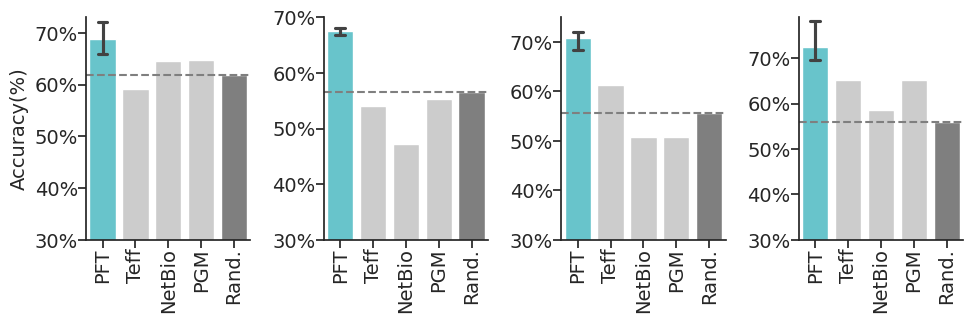

In [14]:
fig,axes = plt.subplots(figsize=(2.5*len(cohort_order), 3.5), nrows=1, ncols=len(cohort_order), sharey=False)

#order = dfp.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
order = ['PFT', 'Teff', 'NetBio', 'PGM', 'Rand.']

ylims = [(0.3, 0.73),(0.3, 0.70),(0.3, 0.75),(0.3, 0.79),(0.3, 0.88), ]
i = 0
for cohort, ax, ylim in zip(cohort_order, axes, ylims):
    dfp1 = dfp[dfp.test_cohort == cohort]
    
    ot = '#cccccc'
    f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()
    
    mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],'Rand.':'#7F7F7F', #random guessing
                    # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                    # 'Teff':f4[8], 'GeneBio':f4[9],
                    'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                    'Teff':ot, 'GeneBio':ot,
                    'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                    'PD1':ot,  'NetBio':ot, 
                    'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot, 
                    }
    
    values = 'ACC'

   
    sns.barplot(data = dfp1, x='mode', y = values, order = order,width = 0.8, capsize = 0.3, 
                 ax=ax, palette=mode_palette) #errorbar = ('ci',80),
    
    # sns.swarmplot(data = dfp1, x='mode', y = values, order = order, 
    #              ax=ax, palette=mode_palette, edgecolor='k', linewidth = 0.5, size=4) #errorbar = ('ci',80),

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    

    rgc_y = dfp1[dfp1['mode'] == 'Rand.'][values].iloc[0]
    ax.axhline(rgc_y, color='#7F7F7F', linestyle='--')

    if i == 0:
        ax.set_ylabel('Accuracy(%)', fontsize=14)

    else:
        ax.set_ylabel(None)
        
    ax.set_ylim(ylim[0], ylim[1]) 
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
        
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=14)

    ax.set_xticklabels(
    order, 
    rotation=90,)  # <====== HERE is the ke
    ax.xaxis.set_tick_params(pad=-0.1)
    ax.yaxis.set_tick_params(pad=-0.1)
        
    ax.set_xlabel('')
    #fig.savefig('./bar_%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )
    i += 1
    
    print(cohort)

fig.tight_layout(w_pad = 1)
fig.savefig('./%s/acc.pdf' % save_dir, bbox_inches = 'tight',)
fig.savefig('./%s/acc.svg' % save_dir, bbox_inches = 'tight',)

PDL1
PD1
CTLA4
PD1+CTLA4
PDL1
PD1
CTLA4
PD1+CTLA4
PDL1
PD1
CTLA4
PD1+CTLA4
PDL1
PD1
CTLA4
PD1+CTLA4


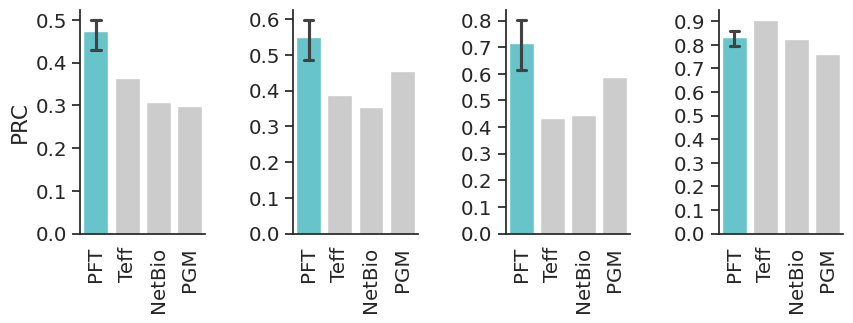

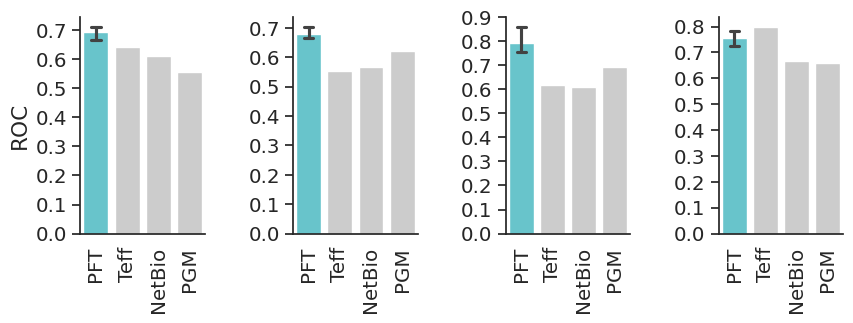

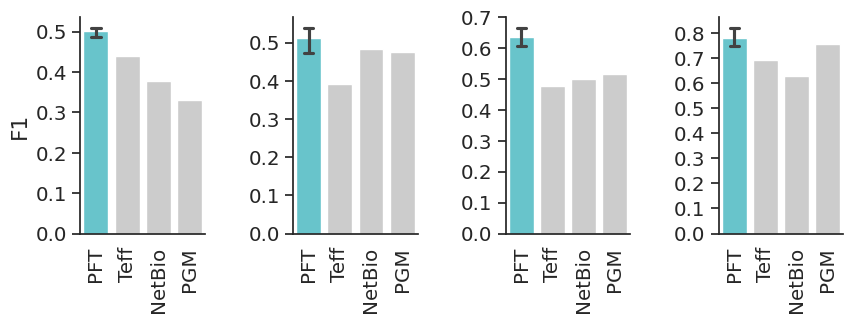

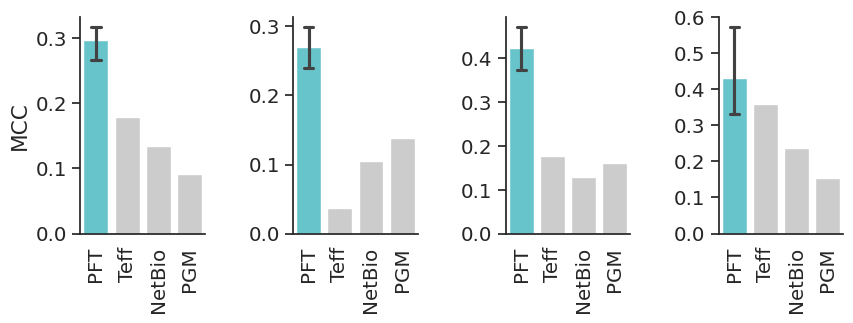

In [15]:
for values in ['PRC', 'ROC', 'F1', 'MCC']:
    fig,axes = plt.subplots(figsize=(2.2*len(rgc), 3.5), nrows=1, ncols=len(rgc), sharey=False)
    #order = dfp.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    order = ['PFT', 'Teff', 'NetBio', 'PGM', ] #'Rand.'
    
    ylims = [(0.3, 0.75),(0.3, 0.70),(0.3, 0.72),(0.3, 0.79),(0.3, 0.88), ]
    i = 0
    for cohort, ax, ylim in zip(cohort_order, axes, ylims):
        dfp1 = dfp[dfp.test_cohort == cohort]
        
        ot = '#cccccc'
        f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()
        
        mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2], 'Rand.':'#7F7F7F', #random guessing
                        # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                        # 'Teff':f4[8], 'GeneBio':f4[9],
                        'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                        'Teff':ot, 'GeneBio':ot,
                        'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                        'PD1':ot,  'NetBio':ot, 
                        'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot, 
                        }

        mydata = dfp1[dfp1['mode'].isin(order)]
        sns.barplot(data = mydata, x='mode', y = values, order = order,width = 0.8, capsize = 0.3, 
                     ax=ax, palette=mode_palette) #errorbar = ('ci',80),
        
        # sns.swarmplot(data = mydata, x='mode', y = values, order = order, 
        #              ax=ax, palette=mode_palette, edgecolor='k', linewidth = 0.5, size=4) #errorbar = ('ci',80),
    
            
        #sns.swarmplot(data = dfp1, x='mode', y =values, order = order,ax=ax)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    
        #rgc_y = dfp1[dfp1['mode'] == 'Rand.'][values].iloc[0]
        #ax.axhline(rgc_y, color='#7F7F7F', linestyle='--')
    
        if i == 0:
            ax.set_ylabel(values)
        else:
            ax.set_ylabel(None)
            
        #ax.set_ylim(ylim[0], ylim[1]) 
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
        
        vals = ax.get_yticks()
        #ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
            
        ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
        
        ax.set_xticklabels(
        order, 
        rotation=90)  # <====== HERE is the ke
        
        ax.set_xlabel('')
        #fig.savefig('./bar_%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )
        i += 1
        
    
        print(cohort)
    
    fig.tight_layout(w_pad = 2)
    fig.savefig('./%s/%s.pdf' % (save_dir, values), bbox_inches = 'tight',)
    fig.savefig('./%s/%s.svg' % (save_dir, values), bbox_inches = 'tight',)


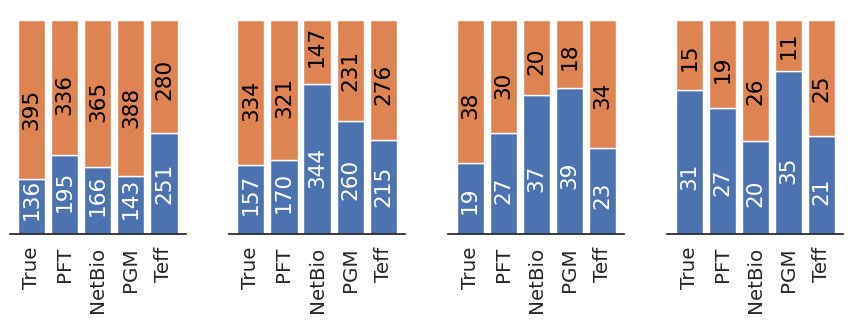

In [16]:
datam = data.groupby(['mode',  'test_cohort', 'Index'])[['R', 'NR', '0', '1']].mean().reset_index()
datam['pred_R'] = datam[['0','1']].idxmax(axis=1).map({'0':0, '1':1})
datam['pred_NR'] = 1-datam['pred_R']

R = datam.groupby(['test_cohort', 'mode']).apply(lambda x:x['R'].sum()).to_frame(name = 'R')
NR = datam.groupby(['test_cohort', 'mode']).apply(lambda x:x['NR'].sum()).to_frame(name = 'NR')
R_pred = datam.groupby(['test_cohort', 'mode']).apply(lambda x:x['pred_R'].sum()).to_frame(name = 'R')
NR_pred = datam.groupby(['test_cohort', 'mode']).apply(lambda x:x['pred_NR'].sum()).to_frame(name = 'NR')

dfd = R.join(NR)
dfd = dfd.drop_duplicates().reset_index()
dfd['mode'] = True

dfd1 = R_pred.join(NR_pred).reset_index()
dfd = dfd._append(dfd1)

dfd['R_prop'] = dfd['R'] / (dfd['R'] + dfd['NR'])
dfd['NR_prop'] = dfd['NR'] / (dfd['R'] + dfd['NR'])


order = [True, 'PFT', 'NetBio', 'PGM', 'Teff']

fig,axes = plt.subplots(figsize=(2.2*len(rgc), 3.5), nrows=1, ncols=len(rgc), sharey=True)
for cohort, ax in zip(cohort_order, axes):
    dfpx = dfd[dfd.test_cohort == cohort].set_index('mode').loc[order]
    dfpx[['R_prop', 'NR_prop']].plot(kind='bar', ax=ax, stacked=True, width = 0.82, legend=False)
    
    # h,l = ax.get_legend_handles_labels()
    # ax.legend(h[:2],["R", "NR"],  ncols =2, fancybox  = True, bbox_to_anchor =  (0.8, 0.95), fontsize=12)
    
    for i, (index, row) in enumerate(dfpx.iterrows()):
        # Annotate the responder count
        ax.text(i, row['R_prop']/3, str(int(row['R'])), ha='center',color='white', rotation=90)
        ax.text(i, row['R_prop'] + row['NR_prop']/3, str(int(row['NR'])), ha='center', color='black', rotation=90)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xlabel(None)
fig.tight_layout(w_pad = 2)
fig.savefig('./%s/binary.pdf' % (save_dir), bbox_inches = 'tight',)
fig.savefig('./%s/binary.svg' % (save_dir), bbox_inches = 'tight',)


In [17]:
# Extract unique cohorts and models
cohorts = cohort_order
modes = [ 'PFT','Teff', 'NetBio', 'PGM']

colors = sns.color_palette('gnuplot', len(modes))

color_map = dict(zip(modes, colors))
compass_cmap = {'PFT':'#36AFCE', 'LFT':'#86CFE2',
                'FFT':'#AFDFEB','NFT':'#D7EFF5', }
color_map.update(compass_cmap)

In [18]:
colors = color_map

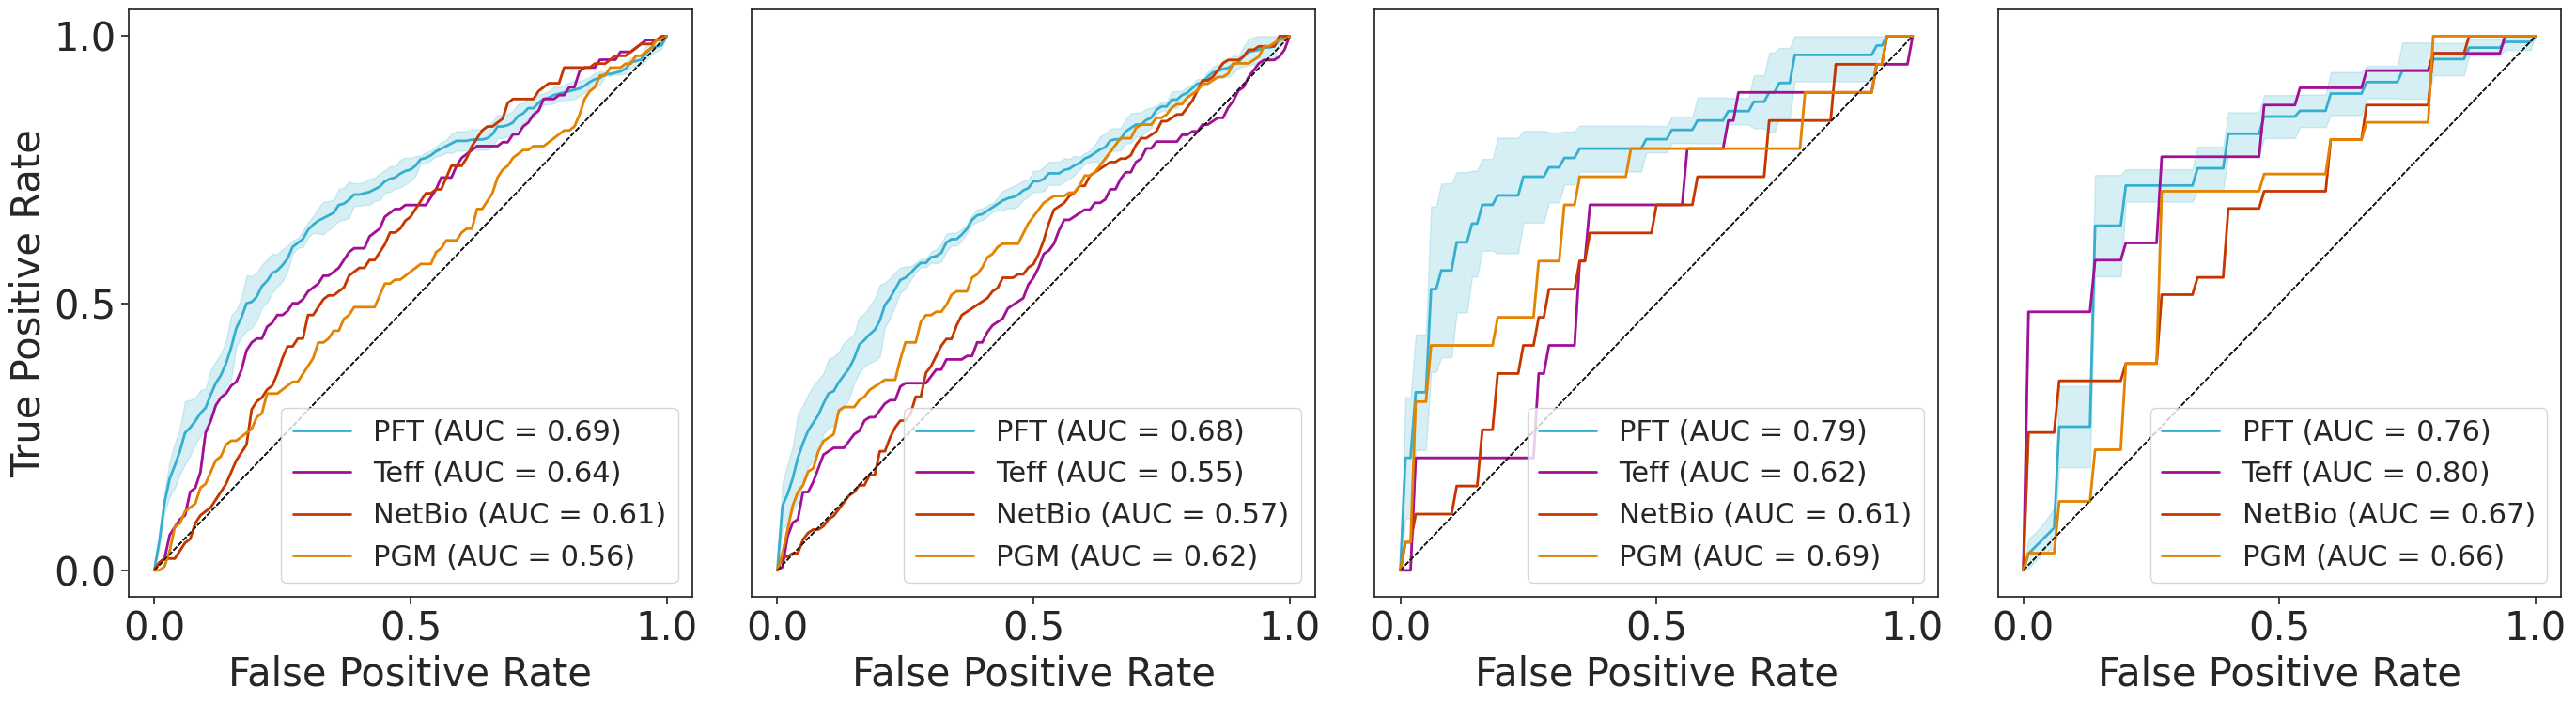

In [22]:
sns.set(style = 'white', font_scale=2.0)
fontsize = 30
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cohorts), figsize=(len(cohort_order)*7., 8), sharey=True)
if len(cohorts) == 1:
    axes = [axes]
i = 0
for ax, cohort in zip(axes, cohorts):
    cohort_data = data[data['test_cohort'] == cohort]
    #ax.set_title(f'Cohort: {cohort}')
    ax.set_xlabel('False Positive Rate',fontsize = fontsize)
    ax.set_ylabel('True Positive Rate',fontsize=fontsize)
    
    for mode in modes:
        mode_data = cohort_data[cohort_data['mode'] == mode]
        seeds = mode_data['seed'].unique()

        color = colors[mode]
        
        tprs = []
        base_fpr = np.linspace(0, 1, 101)
        
        for seed in seeds:
            seed_data = mode_data[mode_data['seed'] == seed]
            fpr, tpr, _ = roc_curve(seed_data['R'], seed_data['1'])
            tprs.append(np.interp(base_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(base_fpr, mean_tpr)
        
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        
        ax.plot(base_fpr, mean_tpr, label=f'{mode} (AUC = {mean_auc:.2f})', color = color, lw=2)
        ax.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.2, color = color)
        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        
    ax.legend(loc='lower right')

    if i == 0:
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=fontsize)
    else:
        ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=fontsize)
        ax.set_ylabel(None)

    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    
    i += 1

    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))


fig.tight_layout(w_pad = 1.2)
plt.show()
fig.savefig('./%s/curve_ROC.pdf' % (save_dir), bbox_inches = 'tight',)
fig.savefig('./%s/curve_ROC.svg' % (save_dir), bbox_inches = 'tight',)


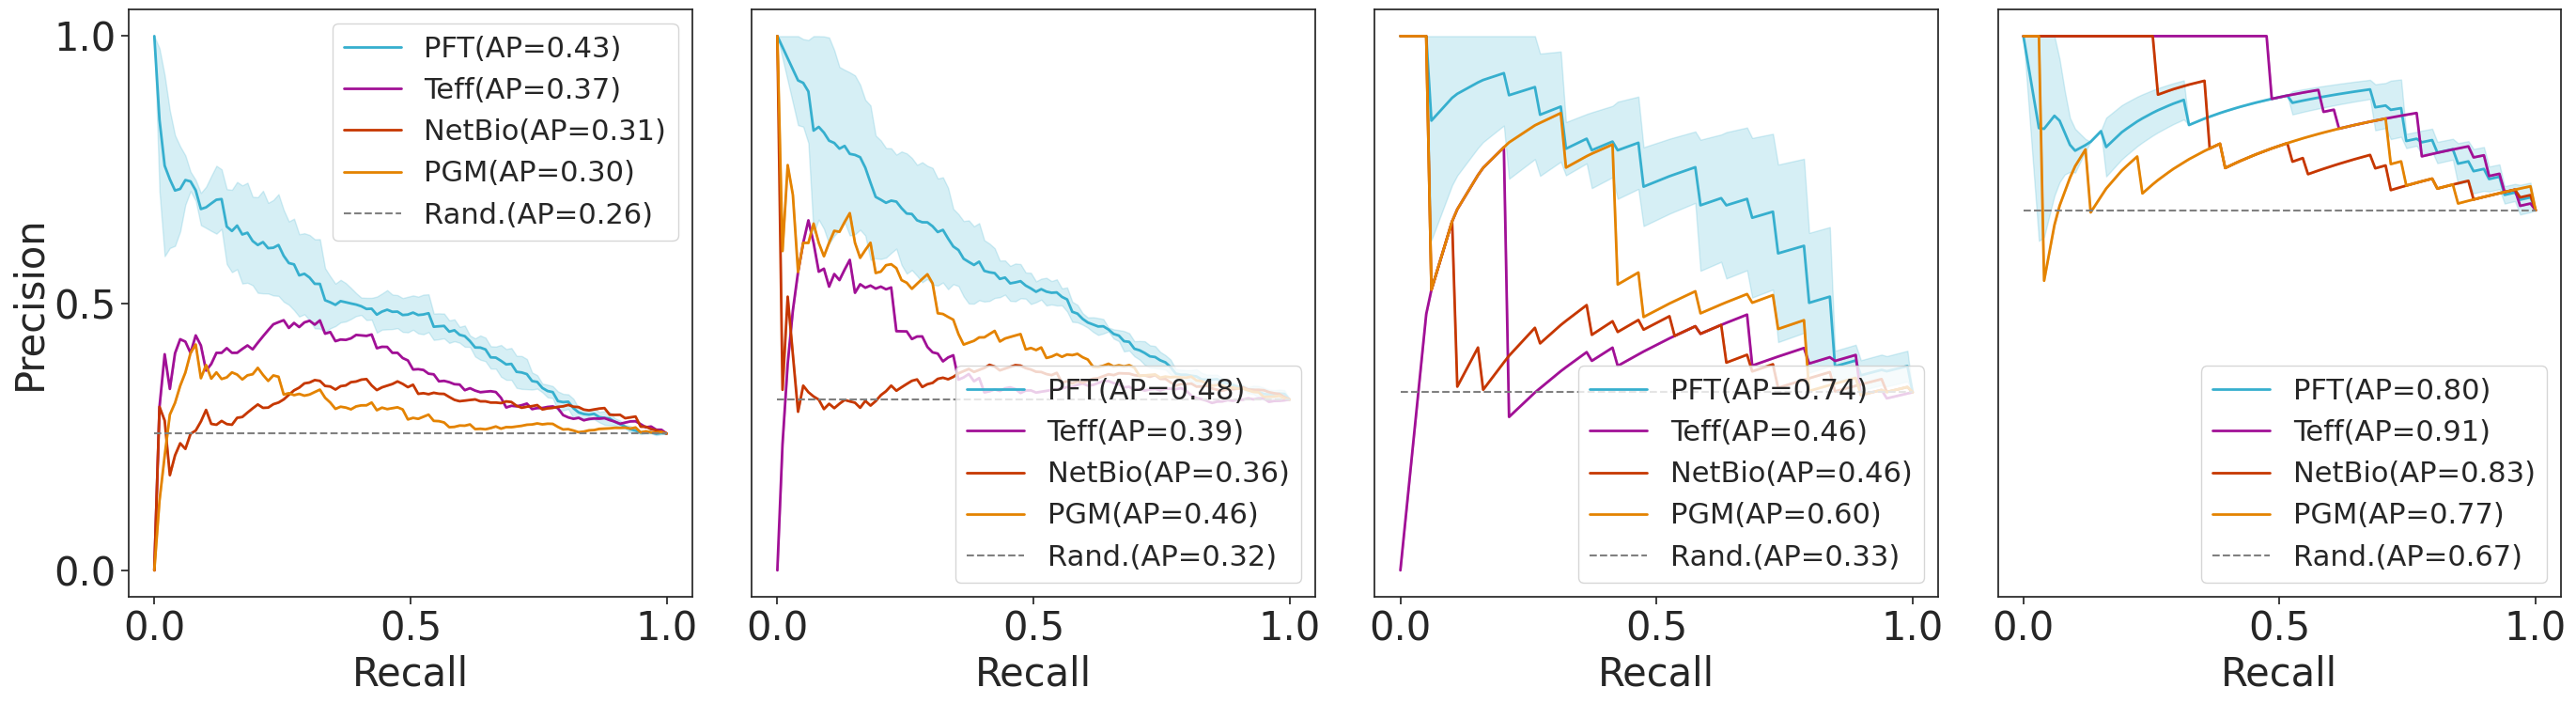

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score
sns.set(style = 'white', font_scale=2.0)



# Calculate the proportion of positive samples for each cohort
cohort_positive_proportions = data.groupby('test_cohort')['R'].mean()

# Create subplots for PRC including Random Guess
fig, axes = plt.subplots(nrows=1, ncols=len(cohorts), figsize=(len(cohort_order)*7., 8), sharey=True)
if len(cohorts) == 1:
    axes = [axes]

i = 0
locs = ['upper right','lower right','lower right', 'lower right', 'lower right']
for ax, cohort,loc in zip(axes, cohorts, locs):
    cohort_data = data[data['test_cohort'] == cohort]
    positive_proportion = cohort_positive_proportions[cohort]
    
    #ax.set_title(f'Cohort: {cohort}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    for mode in modes:
        mode_data = cohort_data[cohort_data['mode'] == mode]
        seeds = mode_data['seed'].unique()
        
        precisions = []
        recalls = []
        thresholds = np.linspace(0, 1, 100)
        
        for seed in seeds:
            seed_data = mode_data[mode_data['seed'] == seed]
            precision, recall, _ = precision_recall_curve(seed_data['R'], seed_data['1'])
            precisions.append(np.interp(thresholds, recall[::-1], precision[::-1])[::-1])
            recalls.append(np.interp(thresholds, recall[::-1], recall[::-1])[::-1])
        
        mean_precision = np.mean(precisions, axis=0)
        mean_recall = np.mean(recalls, axis=0)
        mean_ap = average_precision_score(seed_data['R'], seed_data['1'])
        
        std_precision = np.std(precisions, axis=0)
        precisions_upper = np.minimum(mean_precision + std_precision, 1)
        precisions_lower = np.maximum(mean_precision - std_precision, 0)
        
        color = colors[mode]
        ax.plot(mean_recall, mean_precision, label=f'{mode}(AP={mean_ap:.2f})', color=color,lw=2)
        ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=color, alpha=0.2)

    
    # Plot the random guess line
    ax.plot([0, 1], [positive_proportion, positive_proportion], ls = '--', color = 'grey', 
            label=f'Rand.(AP={positive_proportion:.2f})')
    ax.legend(loc=loc)

    if i == 0:
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=fontsize)
        ax.set_ylabel('Precision', fontsize=fontsize)
        
    else:
        ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True, labelsize=fontsize)
        ax.set_ylabel(None)

    ax.set_xlabel('Recall', fontsize=fontsize)

    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    
    i += 1
    
fig.tight_layout(w_pad = 1.2)
plt.show()

fig.savefig('./%s/curve_PRC.pdf' % (save_dir), bbox_inches = 'tight',)
fig.savefig('./%s/curve_PRC.svg' % (save_dir), bbox_inches = 'tight',)